**Author**: J W Debelius<br/>
**Date**: 26 August 2015<br/>
**virtualenv**: power play

In [11]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

The purpose of this notebook is to test the effect of outliers on traditional power calculations, on emperical power calculations, and on extrapolated power. 

This notebook will focus on using a Case I t test as a model for introducing outliers. We will test the alternative hypotheses that
<center><strong>H</strong><sub>0</sub>: $\bar{x} = 0$<br>
<strong>H</strong><sub>1</sub>: $\bar{x} \neq 0$</center>
for some sample with mean $\bar{x}$ and standard deviation, $s$, drawn from an underlying population with mean, $\mu$ ($\mu \neq 0$) and variance $\sigma^{2}$. 

In [12]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import absloute_power.utils as ap

from absloute_power.traditional import calc_ttest_1
from skbio.stats.power import subsample_power

We can test these hypotheses using the scipy function `scipy.stats.ttest_1samp`.

In [3]:
def emp_ttest_1(samples):
    return scipy.stats.ttest_1samp(samples[0], 0)[1]

In the traditional model of power, the effect size for a sample given by
$\begin{align*}
\lambda &=\frac{(\bar{x} - x)}{s}\\
&= \frac{\bar{x}}{s}\\
&= \frac{t}{\sqrt{n}}
\end{align*}\tag{1}$

We're going to compare the ability of the traditional post-hoc power, emperical post-hoc power and extrapolated post-hoc power to re-capiluate the traditional power calculation. We'll approach this by simuling a random population with a mean, $\mu$ and standard devation, $\sigma$, and then drawing a random sample of size $n$ with mean $\bar{x}$ and standard devation $s$.

In [4]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    mu = np.random.randint(*mu_lim)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    dist = mu + np.random.randn(n) * sigma

    # Draws a sample that fits the parameters
    return [mu, sigma, n], dist

We can design a function that will let us "spike in" outliers: points drawn from a distribution `offset` units above or below the central mean. 

In [5]:
def add_outliers(dist, num_out, offset=50):
    # Draws the offset mean
    if num_out > 0:
        index = np.arange(0, len(dist))
        # Selects the points ot be outliers
        outlier_pos = np.random.choice(np.arange(0, len(dist)), num_out, replace=False)
        # Updates the distribution
        dist[outlier_pos] = dist[outlier_pos] + offset
    
    return [num_out, offset], [dist]

We're going to use the function to simulate several distributions with varying numbers of outliers. We're going to draw distributions with means between 2 and 10, standard deviations between 5 and 15, and at 120 points.

In [6]:
mu_lims = [1, 10]
sigma_lims = [10, 25]
num_counts = 200
count_lims = [num_counts, num_counts+1]

We'll simulate the distributions so they have no outliers, 1%, 2%, 5%, 10% and 20% outliers. The offset mean can fall between -50 and 50 units offset from the original distribution.

In [16]:
num_outliers = (np.concatenate((np.array([0, 1]), np.array([0.01, 0.02, 0.05, 0.1, 0.2])*num_counts))).astype(int)
len_out = len(num_outliers)
offsets = [-50, -25, -10, -5, -2.5, -1, -0.5, 0.5, 1, 5, 10, 25, 50, 100]

When we draw traditional and emperical power, we'll do it starting at 5 samples up to 100 samples, counting by 5s. We draw 100 samples to calculate power for each point, and repeat this three times at each point along the curve. We'll use an alpha value of 0.05. And, we'll simulate 1000 distributions for each number of outliers.

In [17]:
counts = np.arange(10, 101, 10)
alpha=0.05
subsample_params = {'min_counts': 10,
                    'max_counts': 101,
                    'counts_interval': 10,
                    'num_runs': 3,
                    'num_iter': 100,
                    'alpha_pwr': alpha}
num_reps = 100
known_mean = 0

Let's build the simulated populations.

In [18]:
watch = {n: {o: {'pop_params': [], 'base_d': [], 'samp_d': [], 'pseudo_d': []} for o in num_outliers} for n in offsets}
for n in offsets:
    for o in num_outliers:
        v = watch[n][o]
        for i in xrange(num_reps):
            # Draws a sample distribution
            params, sample = ttest_1_simulate(mu_lims, sigma_lims, count_lims)
            # Calculates cohens_d on the base power
            base_d = ap.cohen_d_one_sample(sample, known_mean)
            # calculates the base power
            trad_power = 
            # Spikes in outliers, if necessary
            (num_out, offset), dist = add_outliers(sample, o * base_d, n * params[0] / params[1])
            params.append(num_out)
            params.append(offset)
            # Calculates the effect using the tradtional method
            samp_d = ap.cohen_d_one_sample(dist[0], known_mean)
            #  Calculates the emperical power
            empr_power, empr_counts = subsample_power(emp_ttest_1,
                                                      dist,
                                                      **subsample_params)
            # Calculates the pseudo-effect and confidence interval
            pseudo_d = ap.z_effect(empr_counts, empr_power)

            #Updates watch
            v['pop_params'].append(params)
            v['base_power'].append(trad_power)
            v['samp_power'].append(samp_power)
            v['empr_power'].append(empr_power)
            v['extr_power'].append(extz_power)
        watch[n][o] = v

In [27]:
v2 = pd.DataFrame(watch[-50])
v2

,0,1,2,4,10,20,40
base_d,"[0.364001443907, 0.193749491021, 0.26430067804...","[0.375280978073, 0.199595976079, 0.43206980117...","[0.14955660616, 0.718463510189, 0.76702284747,...","[0.490614409552, 0.281969000385, 0.51147485681...","[0.357163418442, 0.234417939944, 0.06514328178...","[0.475587547142, 0.0697064805078, 0.0274240142...","[0.218846089044, 0.165929439023, 0.46606780284..."
pop_params,"[[9, 23, 200, 0.0, -19.5652173913], [4, 20, 20...","[[8, 20, 200, 0.375280978073, -20.0], [3, 18, ...","[[1, 10, 200, 0.29911321232, -5.0], [8, 11, 20...","[[4, 10, 200, 1.96245763821, -20.0], [4, 12, 2...","[[5, 17, 200, 3.57163418442, -14.7058823529], ...","[[6, 13, 200, 9.51175094284, -23.0769230769], ...","[[2, 10, 200, 8.75384356175, -10.0], [3, 15, 2..."
pseudo_d,"[0.527566620768, 0.23183979155, 0.365778070496...","[0.537451797498, 0.249749319542, 0.61168225394...","[0.173239569144, 0.971327740144, 0.99476815254...","[0.685905756981, 0.372422266095, 0.70968909037...","[0.511727593342, 0.309774639165, 0.04978939975...","[0.539687987885, 0.0672387280271, 0.0602219566...","[0.233866522128, 0.169657690857, 0.31775729085..."
samp_d,"[0.364001443907, 0.193749491021, 0.26430067804...","[0.375280978073, 0.199595976079, 0.43206980117...","[0.14955660616, 0.690813234615, 0.729826828938...","[0.476129256564, 0.275112025965, 0.49536751196...","[0.341853392337, 0.229333948046, 0.06514328178...","[0.382758817611, 0.0673348177764, 0.0274240142...","[0.179361575156, 0.146009614994, 0.22239693649..."


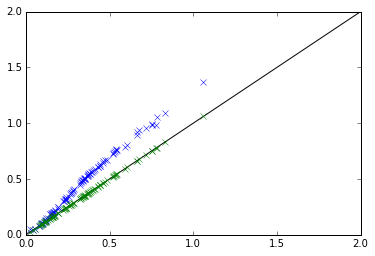

In [34]:
% matplotlib inline
plt.plot(np.arange(0, 2.1, 0.1), np.arange(0, 2.1, 0.1), 'k-')
plt.plot(v2.loc['base_d', 0], v2.loc['pseudo_d', 0], 'x')
plt.plot(v2.loc['base_d', 0], v2.loc['samp_d', 0], 'x')

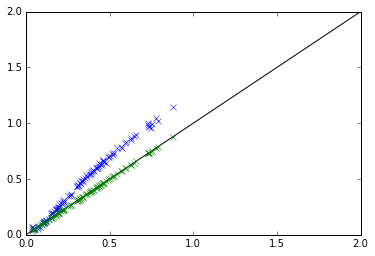

In [35]:
plt.plot(np.arange(0, 2.1, 0.1), np.arange(0, 2.1, 0.1), 'k-')
plt.plot(v2.loc['base_d', 1], v2.loc['pseudo_d', 1], 'x')
plt.plot(v2.loc['base_d', 1], v2.loc['samp_d', 1], 'x')

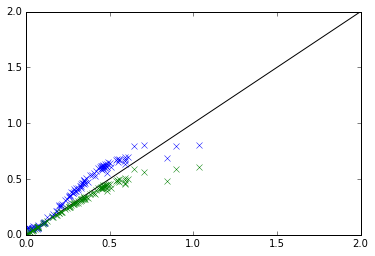

In [36]:
plt.plot(np.arange(0, 2.1, 0.1), np.arange(0, 2.1, 0.1), 'k-')
plt.plot(v2.loc['base_d', 10], v2.loc['pseudo_d', 10], 'x')
plt.plot(v2.loc['base_d', 10], v2.loc['samp_d', 10], 'x')